<a href="https://colab.research.google.com/github/aslestia/ACS_2025/blob/main/ACS_week2_Full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

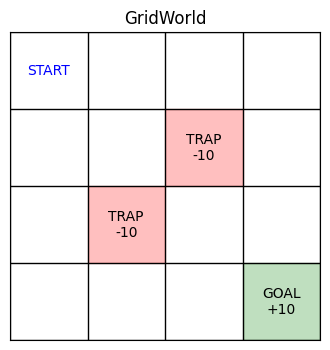

Value Iteration — Values:
 3.2 |  4.4 |  5.7 |  7.1
 4.4 |  3.2 |  0.0 |  8.5
 5.7 |  0.0 |  8.5 | 10.0
 7.1 |  8.5 | 10.0 |  0.0

Value Iteration — Policy:
→ → → ↓
↓ ↑ ■ ↓
↓ ■ → ↓
→ → → ■

Iterasi: 7 | Waktu: 0.0031s
Policy Iteration — Values:
 3.2 |  4.4 |  5.7 |  7.1
 4.4 |  3.2 |  0.0 |  8.5
 5.7 |  0.0 |  8.5 | 10.0
 7.1 |  8.5 | 10.0 |  0.0

Policy Iteration — Policy:
→ → → ↓
↓ ↑ ■ ↓
↓ ■ → ↓
→ → → ■

Iterasi: 6 | Waktu: 0.1520s
== Skenario A (gamma 0.9) ==
gamma=0.9, slip=0.0, step=-1.0
VI iters: 7 | PI iters: 7
== Skenario B (slip 0.1) ==
gamma=0.95, slip=0.1, step=-1.0
VI iters: 24 | PI iters: 4
== Skenario C (trap -5) ==
gamma=0.95, slip=0.0, step=-1.0
VI iters: 7 | PI iters: 6


In [ ]:
#ACS_week2_Gridworlds_DP2
import numpy as np, time, matplotlib.pyplot as plt

# Parameter mudah diubah
H, W = 4, 4
START = (0,0)
GOALS = {(3,3): +10}
TRAPS = {(1,2):-10, (2,1):-10}
STEP_REWARD = -1.0
GAMMA = 0.95
SLIP = 0.0   # 0.1 untuk transisi probabilistik
EPS = 1e-6
ACTIONS = {0: (-1,0), 1: (0,1), 2: (1,0), 3: (0,-1)}   # U,R,D,L
ARROWS  = {0:"↑", 1:"→", 2:"↓", 3:"←", -1:"■"}

class GridWorld:
    def __init__(self, H, W, start, goals, traps, step_reward, gamma, slip=0.0):
        self.H, self.W = H, W
        self.start = start
        self.goals = goals
        self.traps = traps
        self.step_reward = step_reward
        self.gamma = gamma
        self.slip = slip
        self.nS, self.nA = H*W, 4

    def idx(self, s): return s[0]*self.W + s[1]
    def state_from_idx(self, i): return (i//self.W, i%self.W)
    def in_bounds(self, r,c): return 0<=r<self.H and 0<=c<self.W
    def is_terminal(self, s): return s in self.goals or s in self.traps

    def transitions(self, s, a):
        if self.is_terminal(s): return [(1.0, s, 0.0)]
        dr, dc = ACTIONS[a]
        cand = (s[0]+dr, s[1]+dc)
        if not self.in_bounds(*cand): cand = s
        left, right = (a-1)%4, (a+1)%4
        candL = (s[0]+ACTIONS[left][0], s[1]+ACTIONS[left][1])
        candR = (s[0]+ACTIONS[right][0], s[1]+ACTIONS[right][1])
        candL = candL if self.in_bounds(*candL) else s
        candR = candR if self.in_bounds(*candR) else s
        p_main = 1.0 - 2*self.slip
        outs = [(p_main, cand), (self.slip, candL), (self.slip, candR)]
        ts = []
        for p, sn in outs:
            if p<=0: continue
            r = self.goals.get(sn, self.traps.get(sn, self.step_reward))
            ts.append((p, sn, r))
        return ts

def print_values(env, V):
    grid = np.zeros((env.H, env.W))
    for i in range(env.nS):
        r,c = env.state_from_idx(i); grid[r,c] = V[i]
    for r in range(env.H):
        print(" | ".join(f"{grid[r,c]:4.1f}" for c in range(env.W)))
    print()

def print_policy(env, Pi):
    for r in range(env.H):
        row=[]
        for c in range(env.W):
            s=(r,c)
            row.append(ARROWS[-1] if env.is_terminal(s) else ARROWS[Pi[env.idx(s)]])
        print(" ".join(row))
    print()

def show_grid(env):
    fig, ax = plt.subplots(figsize=(4,4))
    for x in range(env.W+1): ax.plot([x,x],[0,env.H],color="k",lw=1)
    for y in range(env.H+1): ax.plot([0,env.W],[y,y],color="k",lw=1)
    for (r,c),val in env.goals.items():
        ax.add_patch(plt.Rectangle((c, r),1,1,color="green",alpha=0.25))
        ax.text(c+0.5,r+0.5,f"GOAL\n{val:+}",ha="center",va="center")
    for (r,c),val in env.traps.items():
        ax.add_patch(plt.Rectangle((c, r),1,1,color="red",alpha=0.25))
        ax.text(c+0.5,r+0.5,f"TRAP\n{val:+}",ha="center",va="center")
    sr,sc = env.start
    ax.text(sc+0.5,sr+0.5,"START",color="blue",ha="center",va="center")
    ax.set_xlim(0,env.W); ax.set_ylim(env.H,0); ax.set_xticks([]); ax.set_yticks([])
    ax.set_title("GridWorld"); plt.show()

# -----------Value Iteration -----------
def value_iteration(env, eps=1e-6, max_iter=1000):
    V = np.zeros(env.nS)
    t0=time.time(); iters=0
    for it in range(max_iter):
        iters=it+1; delta=0.0; V_new=V.copy()
        for i in range(env.nS):
            s=env.state_from_idx(i)
            if env.is_terminal(s): V_new[i]=0.0; continue
            qbest=-1e18
            for a in range(4):
                q=0.0
                for p,sn,r in env.transitions(s,a):
                    q += p*(r + env.gamma*V[env.idx(sn)])
                qbest=max(qbest,q)
            delta=max(delta,abs(qbest-V[i])); V_new[i]=qbest
        V=V_new
        if delta<eps: break
    # greedy policy
    Pi=np.full(env.nS,-1,int)
    for i in range(env.nS):
        s=env.state_from_idx(i)
        if env.is_terminal(s): continue
        qbest,a_best=-1e18,0
        for a in range(4):
            q=0.0
            for p,sn,r in env.transitions(s,a):
                q += p*(r + env.gamma*V[env.idx(sn)])
            if q>qbest: qbest,a_best=q,a
        Pi[i]=a_best
    return V, Pi, iters, time.time()-t0


# ----------- Policy Evaluation -----------
def policy_evaluation(env, Pi, eps=1e-6, max_iter=1000):
    V=np.zeros(env.nS)
    for _ in range(max_iter):
        delta=0.0
        for i in range(env.nS):
            s=env.state_from_idx(i)
            if env.is_terminal(s): newv=0.0
            else:
                a=Pi[i]; newv=0.0
                for p,sn,r in env.transitions(s,a):
                    newv += p*(r + env.gamma*V[env.idx(sn)])
            delta=max(delta,abs(newv-V[i])); V[i]=newv
        if delta<eps: break
    return V

def policy_improvement(env, V):
    Pi=np.full(env.nS,-1,int); stable=True
    for i in range(env.nS):
        s=env.state_from_idx(i)
        if env.is_terminal(s): continue
        best_a,best_q=0,-1e18
        for a in range(4):
            q=0.0
            for p,sn,r in env.transitions(s,a):
                q += p*(r + env.gamma*V[env.idx(sn)])
            if q>best_q: best_q,best_a=q,a
        if Pi[i]!=-1 and Pi[i]!=best_a: stable=False
        Pi[i]=best_a
    return Pi, stable

def policy_iteration(env, eps=1e-6, max_iter=100):
    Pi=np.zeros(env.nS,dtype=int)
    for i in range(env.nS):
        if env.is_terminal(env.state_from_idx(i)): Pi[i]=-1
    t0=time.time(); iters=0
    for k in range(max_iter):
        iters=k+1
        V=policy_evaluation(env,Pi,eps=eps)
        newPi,_=policy_improvement(env,V)
        if np.array_equal(newPi,Pi): return V,Pi,iters,time.time()-t0
        Pi=newPi
    return V,Pi,iters,time.time()-t0

env = GridWorld(H,W,START,GOALS,TRAPS,STEP_REWARD,GAMMA,SLIP)
show_grid(env)

V_vi, Pi_vi, it_vi, t_vi = value_iteration(env, eps=EPS)
print("Value Iteration — Values:"); print_values(env, V_vi)
print("Value Iteration — Policy:"); print_policy(env, Pi_vi)
print(f"Iterasi: {it_vi} | Waktu: {t_vi:.4f}s")

V_pi, Pi_pi, it_pi, t_pi = policy_iteration(env, eps=EPS)
print("Policy Iteration — Values:"); print_values(env, V_pi)
print("Policy Iteration — Policy:"); print_policy(env, Pi_pi)
print(f"Iterasi: {it_pi} | Waktu: {t_pi:.4f}s")

def run_scenario(gamma=0.95, slip=0.0, step=-1.0, goals=None, traps=None, title=""):
    env = GridWorld(H,W,START, goals or GOALS, traps or TRAPS, step, gamma, slip)
    V_vi, Pi_vi, it_vi, _ = value_iteration(env, eps=EPS)
    V_pi, Pi_pi, it_pi, _ = policy_iteration(env, eps=EPS)
    print(f"== {title} ==")
    print(f"gamma={gamma}, slip={slip}, step={step}")
    print("VI iters:", it_vi, "| PI iters:", it_pi)
    return (env, V_vi, Pi_vi, V_pi, Pi_pi)

# Contoh:
_ = run_scenario(gamma=0.9, title="Skenario A (gamma 0.9)")
_ = run_scenario(slip=0.1, title="Skenario B (slip 0.1)")
_ = run_scenario(traps={(1,2):-5,(2,1):-5}, title="Skenario C (trap -5)")